In [1]:
import pandas as pd

# Load the saved CSV file
data = pd.read_csv('processed_data.csv')


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch
from torch.utils.data import Dataset, DataLoader

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

# Define target and input variables
target_cols = ['meanLineIntensity', 'meanNumPixels15']
input_cols = ['Z', 'Wall', 'Overhang', 'NoLines', 'Power', 
                'd_edge_right', 'd_edge_left', 'd_over_left', 
                'd_over_right', 'd_col', 'd_over_z']

# Extract features and targets
X = data[input_cols].values
y = data[target_cols].values

# Create a custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Function to prepare data loaders for a specific fold
def prepare_fold_data(X, y, train_idx, val_idx, batch_size=32):
    # Always use StandardScaler for features
    scaler = StandardScaler()
    scaler_y = StandardScaler()  
    
    # Scale features
    X_train = scaler.fit_transform(X[train_idx])
    X_val = scaler.transform(X[val_idx])
    
    # Scale targets
    y_train = scaler_y.fit_transform(y[train_idx])
    y_val = scaler_y.transform(y[val_idx])
    
    # Create datasets
    train_dataset = CustomDataset(X_train, y_train)
    val_dataset = CustomDataset(X_val, y_val)
    
    # Create data loaders with larger batch size
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False
    )
    
    return train_loader, val_loader, scaler, scaler_y

# Set up K-Fold cross-validation
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Store fold indices for later use
fold_indices = []
for train_idx, val_idx in kf.split(X):
    fold_indices.append((train_idx, val_idx))


In [3]:
def train_k_fold(X, y, fold_indices, hidden_dim=128, num_layers=3, batch_size=32):
    models = []
    scalers = []
    scalers_y = []
    val_scores = []
    r2_scores_all = []

    for fold, (train_idx, val_idx) in enumerate(fold_indices):
        print(f'\nTraining Fold {fold+1}')

        # Prepare data for this fold
        train_loader, val_loader, scaler, scaler_y = prepare_fold_data(
            X, y, train_idx, val_idx, batch_size
        )

        # Initialize model
        model = MLPRegressor(
            input_dim=X.shape[1],
            hidden_dim=hidden_dim,
            num_layers=num_layers,
            output_dim=y.shape[1]
        )
        
        print_model_params(model)

        # Train model and get loss history
        best_model, train_losses, val_losses, epochs = train_model(
            model,
            train_loader,
            val_loader,
            num_epochs=10000,
            patience=500
        )

        # Plot loss evolution for this fold
        plt.figure(figsize=(10, 6))
        plt.plot(epochs[1:], train_losses[1:], label='Training Loss')
        plt.plot(epochs[1:], val_losses[1:], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Loss Evolution - Fold {fold+1}')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Store the trained model and scalers
        models.append(best_model)
        scalers.append(scaler)
        scalers_y.append(scaler_y)

        # Calculate validation scores
        mse, r2_scores, predictions, actuals = evaluate_model(best_model, val_loader, scaler_y)
        val_scores.append(mse)
        r2_scores_all.append(r2_scores)
        print(f'Fold {fold+1} Validation MSE: {mse:.4f}')
        print(f'Fold {fold+1} R² scores: {[f"{r2:.4f}" for r2 in r2_scores]}')

    # Calculate and print average metrics
    print("\nCross-validation Results:")
    print(f"Average MSE: {np.mean(val_scores):.4f} ± {np.std(val_scores):.4f}")
    r2_scores_all = np.array(r2_scores_all)
    for i, target in enumerate(['meanLineIntensity', 'meanNumPixels15']):
        mean_r2 = np.mean(r2_scores_all[:, i])
        std_r2 = np.std(r2_scores_all[:, i])
        print(f"Average R² ({target}): {mean_r2:.4f} ± {std_r2:.4f}")
    
    return models, scalers, scalers_y, val_scores, r2_scores_all

def evaluate_model(model, data_loader, scaler_y):
    model = model.to(device)
    model.eval()
    criterion = nn.MSELoss()
    total_loss = 0.0

    # Lists to store predictions and actual values
    all_predictions = []
    all_actuals = []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)

            # Move to CPU and convert to numpy
            outputs_np = outputs.cpu().numpy()
            y_batch_np = y_batch.cpu().numpy()

            # Inverse transform
            outputs_inv = scaler_y.inverse_transform(outputs_np)
            y_batch_inv = scaler_y.inverse_transform(y_batch_np)

            # Compute loss in original scale
            loss = criterion(torch.tensor(outputs_inv), torch.tensor(y_batch_inv))
            total_loss += loss.item() * X_batch.size(0)

            all_predictions.append(outputs_inv)
            all_actuals.append(y_batch_inv)

    # Convert lists to numpy arrays
    predictions = np.vstack(all_predictions)
    actuals = np.vstack(all_actuals)

    # Calculate MSE
    mse = total_loss / len(data_loader.dataset)

    # Calculate R2 for each target
    r2_scores = []
    for i in range(actuals.shape[1]):
        ss_res = np.sum((actuals[:, i] - predictions[:, i]) ** 2)
        ss_tot = np.sum((actuals[:, i] - np.mean(actuals[:, i])) ** 2)
        r2 = 1 - (ss_res / ss_tot)
        r2_scores.append(r2)

    # Create plots
    import matplotlib.pyplot as plt

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    target_names = ['meanLineIntensity', 'meanNumPixels15']

    for i, (ax, target) in enumerate(zip(axes, target_names)):
        # Plot predicted vs actual
        ax.scatter(actuals[:, i], predictions[:, i], alpha=0.5)

        # Plot perfect prediction line
        min_val = min(actuals[:, i].min(), predictions[:, i].min())
        max_val = max(actuals[:, i].max(), predictions[:, i].max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')

        # Add labels and title
        ax.set_xlabel('Actual Values')
        ax.set_ylabel('Predicted Values')
        ax.set_title(f'{target}\nR² = {r2_scores[i]:.4f}')
        ax.grid(True)
        ax.legend()

    plt.tight_layout()
    plt.show()

    # Print detailed metrics
    print("\nEvaluation Metrics:")
    print(f"MSE: {mse:.4f}")
    for i, target in enumerate(target_names):
        print(f"R² ({target}): {r2_scores[i]:.4f}")

    return mse, r2_scores, predictions, actuals

def print_model_params(model):
    """Print model parameters count by layer"""
    total_params = 0
    input_params = sum(p.numel() for p in model.input_layer.parameters())
    total_params += input_params
    print(f"Input layer parameters: {input_params:,}")
    
    for i, block in enumerate(model.residual_layers):
        block_params = sum(p.numel() for p in block.parameters())
        total_params += block_params
        print(f"Residual block {i+1} parameters: {block_params:,}")
    
    output_params = sum(p.numel() for p in model.output_layer.parameters())
    total_params += output_params
    print(f"Output layer parameters: {output_params:,}")
    
    print("-" * 50)
    print(f"Total Parameters: {total_params:,}")
    


Training Fold 1
Input layer parameters: 2,122,752
Residual block 1 parameters: 6,295,552
Residual block 2 parameters: 6,295,552
Residual block 3 parameters: 6,295,552
Residual block 4 parameters: 6,295,552
Residual block 5 parameters: 6,295,552
Residual block 6 parameters: 6,295,552
Residual block 7 parameters: 6,295,552
Residual block 8 parameters: 6,295,552
Residual block 9 parameters: 6,295,552
Residual block 10 parameters: 6,295,552
Residual block 11 parameters: 6,295,552
Residual block 12 parameters: 6,295,552
Residual block 13 parameters: 6,295,552
Residual block 14 parameters: 6,295,552
Residual block 15 parameters: 6,295,552
Residual block 16 parameters: 6,295,552
Residual block 17 parameters: 6,295,552
Residual block 18 parameters: 6,295,552
Residual block 19 parameters: 6,295,552
Residual block 20 parameters: 6,295,552
Residual block 21 parameters: 6,295,552
Residual block 22 parameters: 6,295,552
Residual block 23 parameters: 6,295,552
Residual block 24 parameters: 6,295,55

Epoch [590/10000], LR: 0.000001, Train Loss: 0.293840, Val Loss: 0.297737
Epoch [600/10000], LR: 0.000001, Train Loss: 0.295636, Val Loss: 0.298640
Epoch [610/10000], LR: 0.000001, Train Loss: 0.296802, Val Loss: 0.298401
Epoch [620/10000], LR: 0.000001, Train Loss: 0.297496, Val Loss: 0.297996
Epoch [630/10000], LR: 0.000001, Train Loss: 0.294716, Val Loss: 0.298092
Epoch [640/10000], LR: 0.000001, Train Loss: 0.297476, Val Loss: 0.298469
Epoch [650/10000], LR: 0.000001, Train Loss: 0.296492, Val Loss: 0.298054
Epoch [660/10000], LR: 0.000001, Train Loss: 0.293402, Val Loss: 0.298611
Epoch [670/10000], LR: 0.000001, Train Loss: 0.297945, Val Loss: 0.298425
Epoch [680/10000], LR: 0.000001, Train Loss: 0.301540, Val Loss: 0.298738
Epoch [690/10000], LR: 0.000001, Train Loss: 0.298511, Val Loss: 0.299031
Epoch [700/10000], LR: 0.000001, Train Loss: 0.298849, Val Loss: 0.298487
Epoch [710/10000], LR: 0.000001, Train Loss: 0.291286, Val Loss: 0.298727
Epoch [720/10000], LR: 0.000001, Train

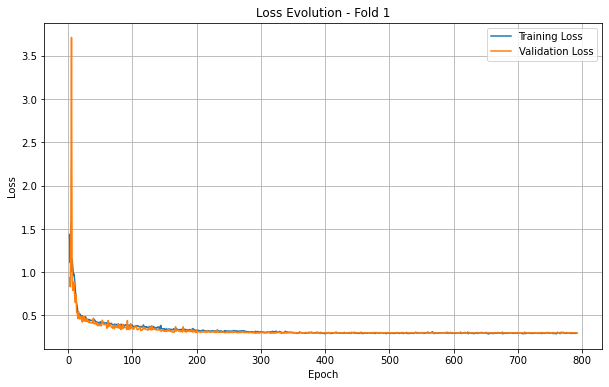

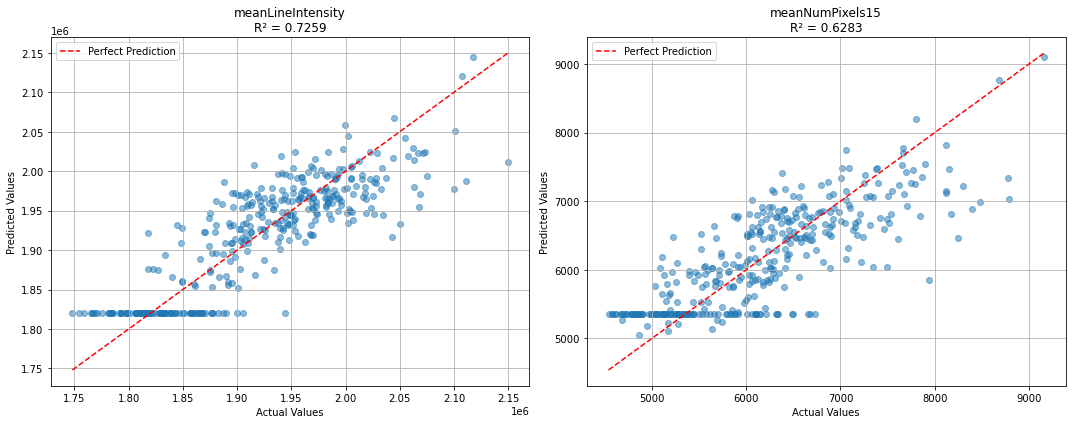


Evaluation Metrics:
MSE: 839913584.4848
R² (meanLineIntensity): 0.7259
R² (meanNumPixels15): 0.6283
Fold 1 Validation MSE: 839913584.4848
Fold 1 R² scores: ['0.7259', '0.6283']

Training Fold 2
Input layer parameters: 2,122,752
Residual block 1 parameters: 6,295,552
Residual block 2 parameters: 6,295,552
Residual block 3 parameters: 6,295,552
Residual block 4 parameters: 6,295,552
Residual block 5 parameters: 6,295,552
Residual block 6 parameters: 6,295,552
Residual block 7 parameters: 6,295,552
Residual block 8 parameters: 6,295,552
Residual block 9 parameters: 6,295,552
Residual block 10 parameters: 6,295,552
Residual block 11 parameters: 6,295,552
Residual block 12 parameters: 6,295,552
Residual block 13 parameters: 6,295,552
Residual block 14 parameters: 6,295,552
Residual block 15 parameters: 6,295,552
Residual block 16 parameters: 6,295,552
Residual block 17 parameters: 6,295,552
Residual block 18 parameters: 6,295,552
Residual block 19 parameters: 6,295,552
Residual block 20 pa

Epoch [560/10000], LR: 0.000063, Train Loss: 0.263247, Val Loss: 0.280863
Epoch [570/10000], LR: 0.000063, Train Loss: 0.262194, Val Loss: 0.275426
Epoch [580/10000], LR: 0.000063, Train Loss: 0.264523, Val Loss: 0.275371
Epoch [590/10000], LR: 0.000063, Train Loss: 0.264763, Val Loss: 0.269359
Epoch [600/10000], LR: 0.000063, Train Loss: 0.255181, Val Loss: 0.280799
Epoch [610/10000], LR: 0.000063, Train Loss: 0.262179, Val Loss: 0.274499
Epoch [620/10000], LR: 0.000063, Train Loss: 0.261358, Val Loss: 0.272453
Epoch [630/10000], LR: 0.000031, Train Loss: 0.258136, Val Loss: 0.269976
Epoch [640/10000], LR: 0.000031, Train Loss: 0.253374, Val Loss: 0.269405
Epoch [650/10000], LR: 0.000031, Train Loss: 0.252949, Val Loss: 0.267189
Epoch [660/10000], LR: 0.000031, Train Loss: 0.253210, Val Loss: 0.266429
Epoch [670/10000], LR: 0.000031, Train Loss: 0.258356, Val Loss: 0.263245
Epoch [680/10000], LR: 0.000031, Train Loss: 0.244642, Val Loss: 0.265903
Epoch [690/10000], LR: 0.000031, Train

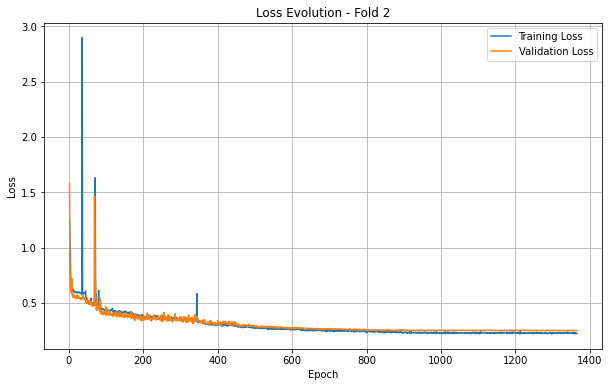

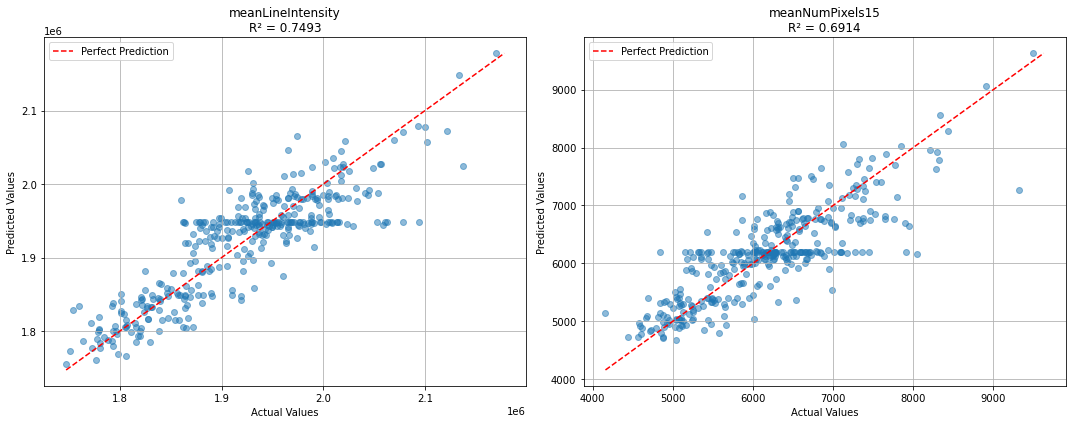


Evaluation Metrics:
MSE: 778244160.5289
R² (meanLineIntensity): 0.7493
R² (meanNumPixels15): 0.6914
Fold 2 Validation MSE: 778244160.5289
Fold 2 R² scores: ['0.7493', '0.6914']

Training Fold 3
Input layer parameters: 2,122,752
Residual block 1 parameters: 6,295,552
Residual block 2 parameters: 6,295,552
Residual block 3 parameters: 6,295,552
Residual block 4 parameters: 6,295,552
Residual block 5 parameters: 6,295,552
Residual block 6 parameters: 6,295,552
Residual block 7 parameters: 6,295,552
Residual block 8 parameters: 6,295,552
Residual block 9 parameters: 6,295,552
Residual block 10 parameters: 6,295,552
Residual block 11 parameters: 6,295,552
Residual block 12 parameters: 6,295,552
Residual block 13 parameters: 6,295,552
Residual block 14 parameters: 6,295,552
Residual block 15 parameters: 6,295,552
Residual block 16 parameters: 6,295,552
Residual block 17 parameters: 6,295,552
Residual block 18 parameters: 6,295,552
Residual block 19 parameters: 6,295,552
Residual block 20 pa

Epoch [560/10000], LR: 0.000008, Train Loss: 0.283519, Val Loss: 0.349247
Epoch [570/10000], LR: 0.000008, Train Loss: 0.290773, Val Loss: 0.348673
Epoch [580/10000], LR: 0.000004, Train Loss: 0.282279, Val Loss: 0.347900
Epoch [590/10000], LR: 0.000004, Train Loss: 0.287923, Val Loss: 0.348138
Epoch [600/10000], LR: 0.000004, Train Loss: 0.292374, Val Loss: 0.348794
Epoch [610/10000], LR: 0.000002, Train Loss: 0.289667, Val Loss: 0.348448
Epoch [620/10000], LR: 0.000002, Train Loss: 0.280715, Val Loss: 0.348361
Epoch [630/10000], LR: 0.000002, Train Loss: 0.284376, Val Loss: 0.348263
Epoch [640/10000], LR: 0.000002, Train Loss: 0.285968, Val Loss: 0.348791
Epoch [650/10000], LR: 0.000001, Train Loss: 0.288211, Val Loss: 0.348518
Epoch [660/10000], LR: 0.000001, Train Loss: 0.290308, Val Loss: 0.348534
Epoch [670/10000], LR: 0.000001, Train Loss: 0.288565, Val Loss: 0.348661
Epoch [680/10000], LR: 0.000001, Train Loss: 0.286432, Val Loss: 0.348539
Epoch [690/10000], LR: 0.000001, Train

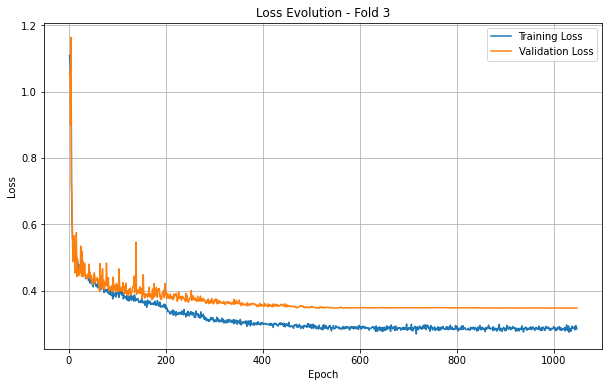

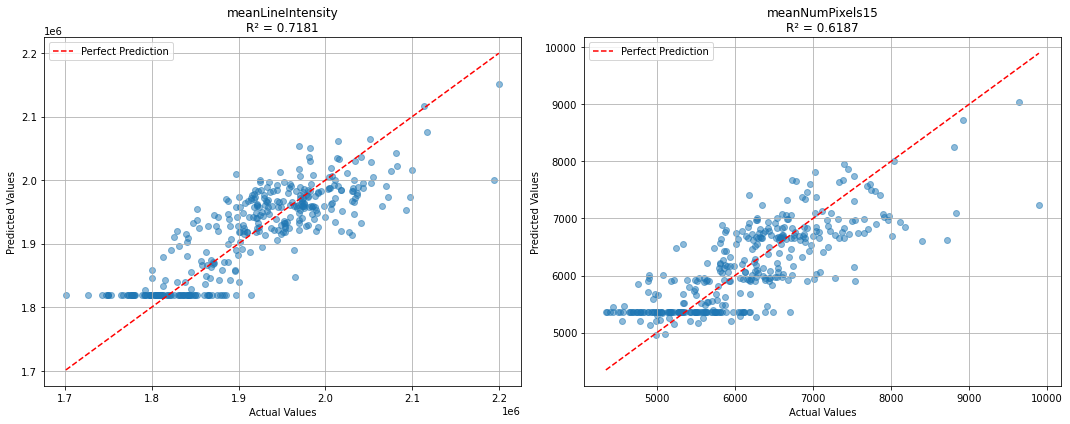


Evaluation Metrics:
MSE: 1024282102.0994
R² (meanLineIntensity): 0.7181
R² (meanNumPixels15): 0.6187
Fold 3 Validation MSE: 1024282102.0994
Fold 3 R² scores: ['0.7181', '0.6187']

Training Fold 4
Input layer parameters: 2,122,752
Residual block 1 parameters: 6,295,552
Residual block 2 parameters: 6,295,552
Residual block 3 parameters: 6,295,552
Residual block 4 parameters: 6,295,552
Residual block 5 parameters: 6,295,552
Residual block 6 parameters: 6,295,552
Residual block 7 parameters: 6,295,552
Residual block 8 parameters: 6,295,552
Residual block 9 parameters: 6,295,552
Residual block 10 parameters: 6,295,552
Residual block 11 parameters: 6,295,552
Residual block 12 parameters: 6,295,552
Residual block 13 parameters: 6,295,552
Residual block 14 parameters: 6,295,552
Residual block 15 parameters: 6,295,552
Residual block 16 parameters: 6,295,552
Residual block 17 parameters: 6,295,552
Residual block 18 parameters: 6,295,552
Residual block 19 parameters: 6,295,552
Residual block 20 

Epoch [560/10000], LR: 0.000001, Train Loss: 0.284177, Val Loss: 0.404231
Epoch [570/10000], LR: 0.000001, Train Loss: 0.280178, Val Loss: 0.404400
Epoch [580/10000], LR: 0.000001, Train Loss: 0.290432, Val Loss: 0.404375
Epoch [590/10000], LR: 0.000001, Train Loss: 0.286983, Val Loss: 0.404054
Epoch [600/10000], LR: 0.000001, Train Loss: 0.290578, Val Loss: 0.403802
Epoch [610/10000], LR: 0.000001, Train Loss: 0.279770, Val Loss: 0.404094
Epoch [620/10000], LR: 0.000001, Train Loss: 0.284465, Val Loss: 0.403910
Epoch [630/10000], LR: 0.000001, Train Loss: 0.287531, Val Loss: 0.403911
Epoch [640/10000], LR: 0.000001, Train Loss: 0.288076, Val Loss: 0.403957
Epoch [650/10000], LR: 0.000001, Train Loss: 0.282538, Val Loss: 0.403986
Epoch [660/10000], LR: 0.000001, Train Loss: 0.281503, Val Loss: 0.404427
Epoch [670/10000], LR: 0.000001, Train Loss: 0.288345, Val Loss: 0.404106
Epoch [680/10000], LR: 0.000001, Train Loss: 0.289486, Val Loss: 0.404176
Epoch [690/10000], LR: 0.000001, Train

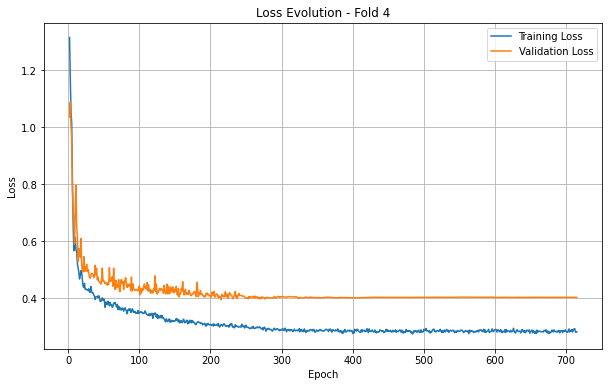

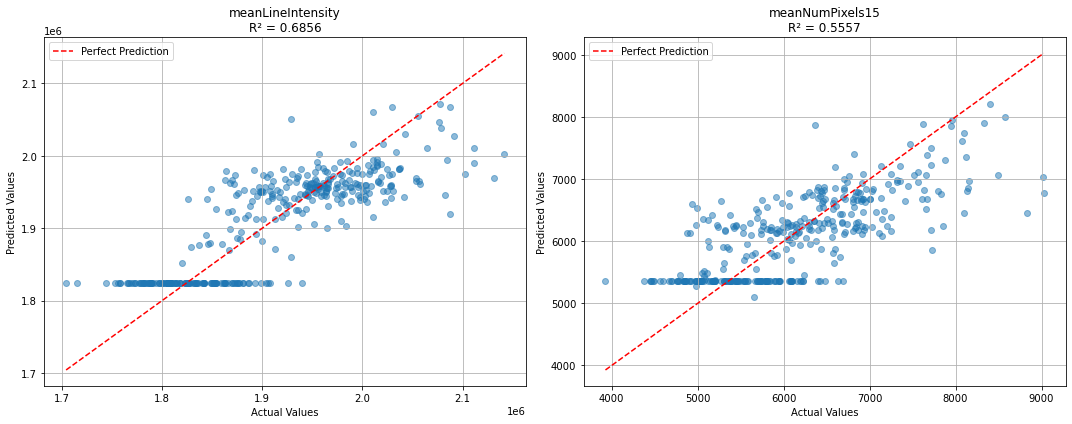


Evaluation Metrics:
MSE: 1156094476.7293
R² (meanLineIntensity): 0.6856
R² (meanNumPixels15): 0.5557
Fold 4 Validation MSE: 1156094476.7293
Fold 4 R² scores: ['0.6856', '0.5557']

Training Fold 5
Input layer parameters: 2,122,752
Residual block 1 parameters: 6,295,552
Residual block 2 parameters: 6,295,552
Residual block 3 parameters: 6,295,552
Residual block 4 parameters: 6,295,552
Residual block 5 parameters: 6,295,552
Residual block 6 parameters: 6,295,552
Residual block 7 parameters: 6,295,552
Residual block 8 parameters: 6,295,552
Residual block 9 parameters: 6,295,552
Residual block 10 parameters: 6,295,552
Residual block 11 parameters: 6,295,552
Residual block 12 parameters: 6,295,552
Residual block 13 parameters: 6,295,552
Residual block 14 parameters: 6,295,552
Residual block 15 parameters: 6,295,552
Residual block 16 parameters: 6,295,552
Residual block 17 parameters: 6,295,552
Residual block 18 parameters: 6,295,552
Residual block 19 parameters: 6,295,552
Residual block 20 

Epoch [560/10000], LR: 0.000250, Train Loss: 0.362633, Val Loss: 0.356757
Epoch [570/10000], LR: 0.000250, Train Loss: 0.363526, Val Loss: 0.351112
Epoch [580/10000], LR: 0.000250, Train Loss: 0.362163, Val Loss: 0.355123
Epoch [590/10000], LR: 0.000125, Train Loss: 0.357114, Val Loss: 0.346155
Epoch [600/10000], LR: 0.000125, Train Loss: 0.357164, Val Loss: 0.354584
Epoch [610/10000], LR: 0.000125, Train Loss: 0.357329, Val Loss: 0.349366
Epoch [620/10000], LR: 0.000125, Train Loss: 0.353783, Val Loss: 0.353504
Epoch [630/10000], LR: 0.000063, Train Loss: 0.353193, Val Loss: 0.352890
Epoch [640/10000], LR: 0.000063, Train Loss: 0.357021, Val Loss: 0.350271
Epoch [650/10000], LR: 0.000063, Train Loss: 0.350463, Val Loss: 0.351041
Epoch [660/10000], LR: 0.000063, Train Loss: 0.350135, Val Loss: 0.347650
Epoch [670/10000], LR: 0.000031, Train Loss: 0.350758, Val Loss: 0.347951
Epoch [680/10000], LR: 0.000031, Train Loss: 0.348247, Val Loss: 0.345321
Epoch [690/10000], LR: 0.000031, Train

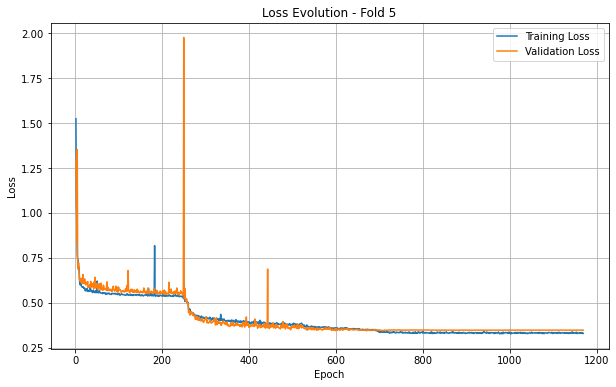

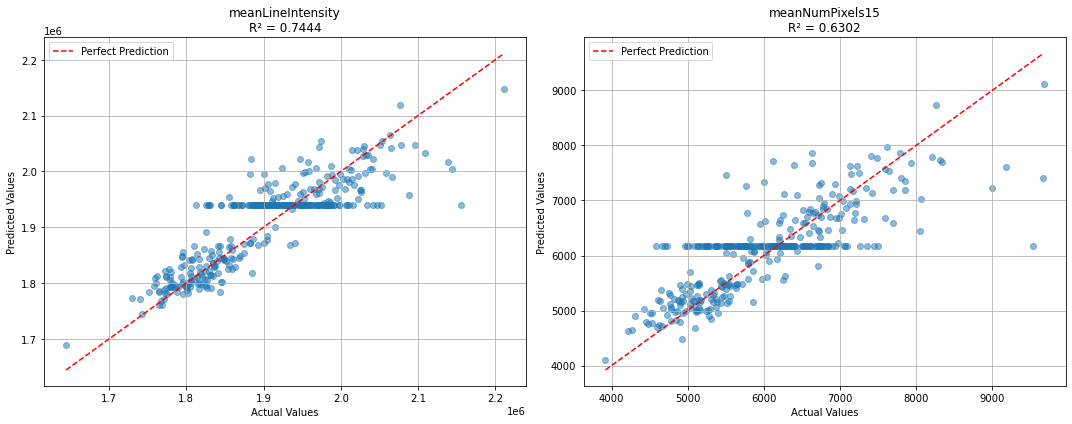


Evaluation Metrics:
MSE: 977411582.2320
R² (meanLineIntensity): 0.7444
R² (meanNumPixels15): 0.6302
Fold 5 Validation MSE: 977411582.2320
Fold 5 R² scores: ['0.7444', '0.6302']

Cross-validation Results:
Average MSE: 955189181.2149 ± 134334365.0270
Average R² (meanLineIntensity): 0.7247 ± 0.0226
Average R² (meanNumPixels15): 0.6249 ± 0.0431


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import copy
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np

class ResidualBlock(nn.Module):
    def __init__(self, dim, dropout_rate=0.1):
        super(ResidualBlock, self).__init__()
        expansion = 3
        self.block = nn.Sequential(
            nn.Linear(dim, dim * expansion),
            nn.ReLU(),  
            nn.Dropout(dropout_rate),
            nn.Linear(dim * expansion, dim),
        )
        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0.01)  
                
    def forward(self, x):
        return x + 0.1 * self.block(x)  

class MLPRegressor(nn.Module):
    def __init__(self, input_dim=5, hidden_dim=128, num_layers=3, output_dim=2, dropout_rate=0.1):
        super(MLPRegressor, self).__init__()
        
        self.input_layer = nn.Sequential(
            nn.Linear(input_dim, hidden_dim * 2),  
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU()
        )
        
        self.residual_layers = nn.ModuleList([
            ResidualBlock(hidden_dim, dropout_rate) 
            for _ in range(num_layers - 1)
        ])
        
        self.output_layer = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, output_dim)
        )
        
        # Initialize
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0.01)
                
    def forward(self, x):
        x = self.input_layer(x)
        for layer in self.residual_layers:
            x = layer(x)
        return self.output_layer(x)

def train_model(model, train_loader, val_loader, num_epochs=1000, patience=50):
    model = model.to(device)
    criterion = nn.MSELoss()
    
    optimizer = optim.AdamW(
        model.parameters(),
        lr=0.0005,  
        weight_decay=1e-5,
        eps=1e-8  
    )
    
    scheduler = ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,  
        patience=30,
        min_lr=1e-6,
        eps=1e-8
    )

    best_val_loss = float('inf')
    best_model = None
    patience_counter = 0
    
    train_losses = []
    val_losses = []
    epochs = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            outputs = model(X_batch)
            
            loss = criterion(outputs, y_batch)
            
            # Check for NaN loss
            if torch.isnan(loss):
                print(f"NaN loss detected at epoch {epoch+1}")
                return None, train_losses, val_losses, epochs
            
            loss.backward()
            
            # gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)

        train_loss /= len(train_loader.dataset)

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item() * X_batch.size(0)

        val_loss /= len(val_loader.dataset)

        scheduler.step(val_loss)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        epochs.append(epoch + 1)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model)
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f'Early stopping triggered at epoch {epoch+1}')
            break

        if (epoch + 1) % 10 == 0:
            current_lr = optimizer.param_groups[0]['lr']
            print(f'Epoch [{epoch+1}/{num_epochs}], LR: {current_lr:.6f}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')

    return best_model, train_losses, val_losses, epochs

models, scalers, scalers_y, val_scores, r2_scores_all = train_k_fold(
    X, y, 
    fold_indices, 
    hidden_dim=1024,     
    num_layers=96,     
    batch_size=32
)

In [5]:
import os
import json
import pickle
import torch
from datetime import datetime

def save_training_results(models, scalers, scalers_y, val_scores, r2_scores_all, input_cols, target_cols):
    # Create Results directory if it doesn't exist
    results_dir = "Results"
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)
    
    # Create timestamped subdirectory for this training run
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    run_dir = os.path.join(results_dir, f"run_{timestamp}")
    os.makedirs(run_dir)
    
    # Save models
    models_dir = os.path.join(run_dir, "models")
    os.makedirs(models_dir)
    for i, model in enumerate(models):
        model_path = os.path.join(models_dir, f"model_fold_{i+1}.pt")
        torch.save(model.state_dict(), model_path)
    
    # Save scalers
    scalers_dir = os.path.join(run_dir, "scalers")
    os.makedirs(scalers_dir)
    for i, (scaler, scaler_y) in enumerate(zip(scalers, scalers_y)):
        # Save feature scaler
        scaler_path = os.path.join(scalers_dir, f"feature_scaler_fold_{i+1}.pkl")
        with open(scaler_path, 'wb') as f:
            pickle.dump(scaler, f)
        
        # Save target scaler
        scaler_y_path = os.path.join(scalers_dir, f"target_scaler_fold_{i+1}.pkl")
        with open(scaler_y_path, 'wb') as f:
            pickle.dump(scaler_y, f)
    
    # Save metrics and configuration
    metrics = {
        'input_features': input_cols,
        'target_variables': target_cols,
        'val_scores': val_scores.tolist() if isinstance(val_scores, np.ndarray) else val_scores,
        'r2_scores_all': r2_scores_all.tolist() if isinstance(r2_scores_all, np.ndarray) else r2_scores_all,
        'average_mse': float(np.mean(val_scores)),
        'mse_std': float(np.std(val_scores)),
        'average_r2_by_target': {
            target: {
                'mean': float(np.mean(r2_scores_all[:, i])),
                'std': float(np.std(r2_scores_all[:, i]))
            }
            for i, target in enumerate(target_cols)
        }
    }
    
    metrics_path = os.path.join(run_dir, "metrics.json")
    with open(metrics_path, 'w') as f:
        json.dump(metrics, f, indent=4)
    
    print(f"\nResults saved in: {run_dir}")
    print("Saved contents:")
    print(f"- {len(models)} models")
    print(f"- {len(scalers)} feature scalers and target scalers")
    print("- Evaluation metrics and configuration")

# Call the function to save the results
save_training_results(
    models=models,
    scalers=scalers,
    scalers_y=scalers_y,  
    val_scores=val_scores,
    r2_scores_all=r2_scores_all,
    input_cols=input_cols,
    target_cols=target_cols
)


Results saved in: Results/run_20241117_090302
Saved contents:
- 5 models
- 5 feature scalers and target scalers
- Evaluation metrics and configuration


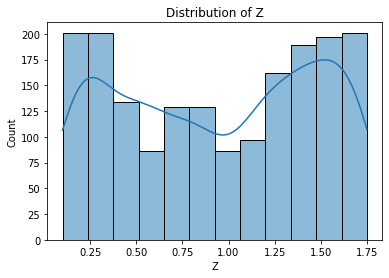

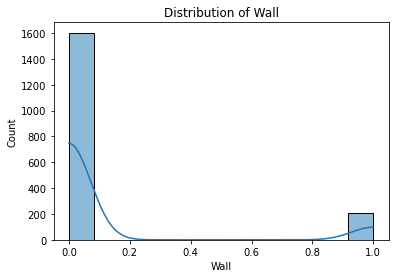

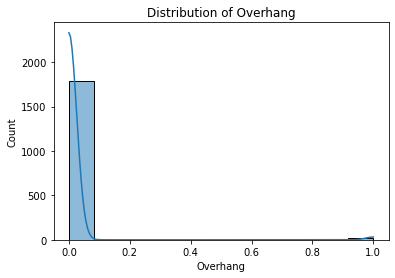

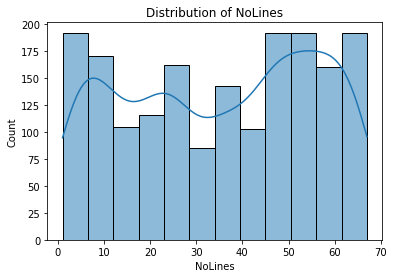

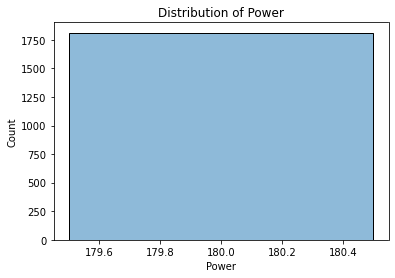

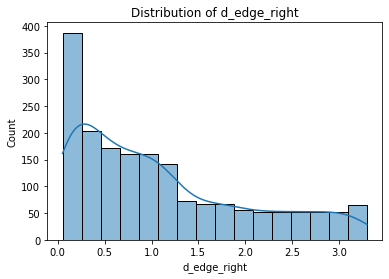

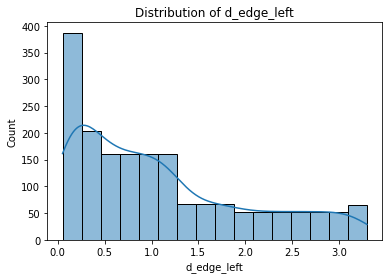

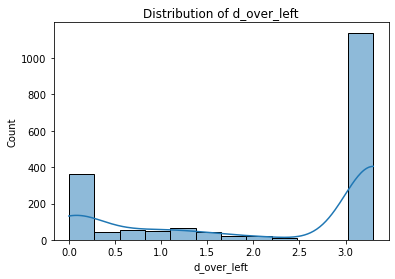

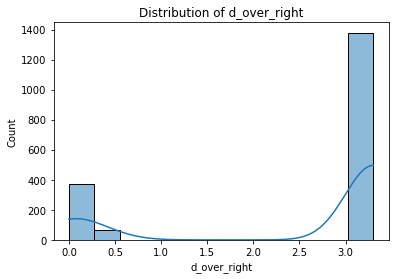

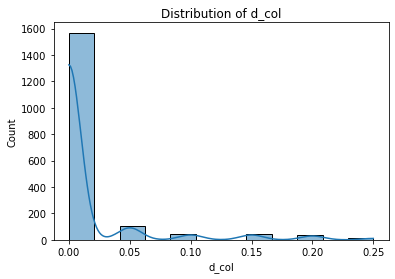

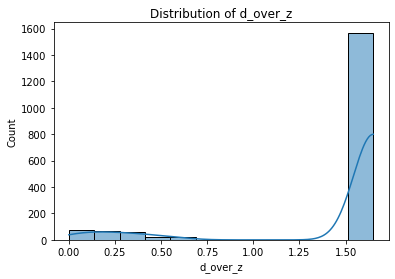

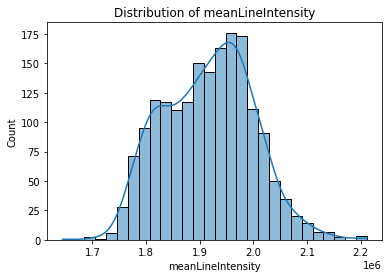

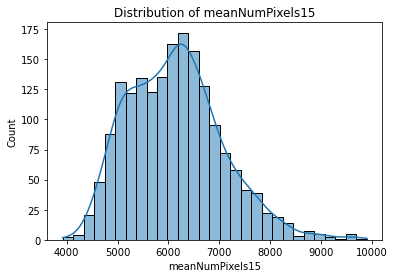

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot histograms for each feature
for col in input_cols + target_cols:
    sns.histplot(data[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()


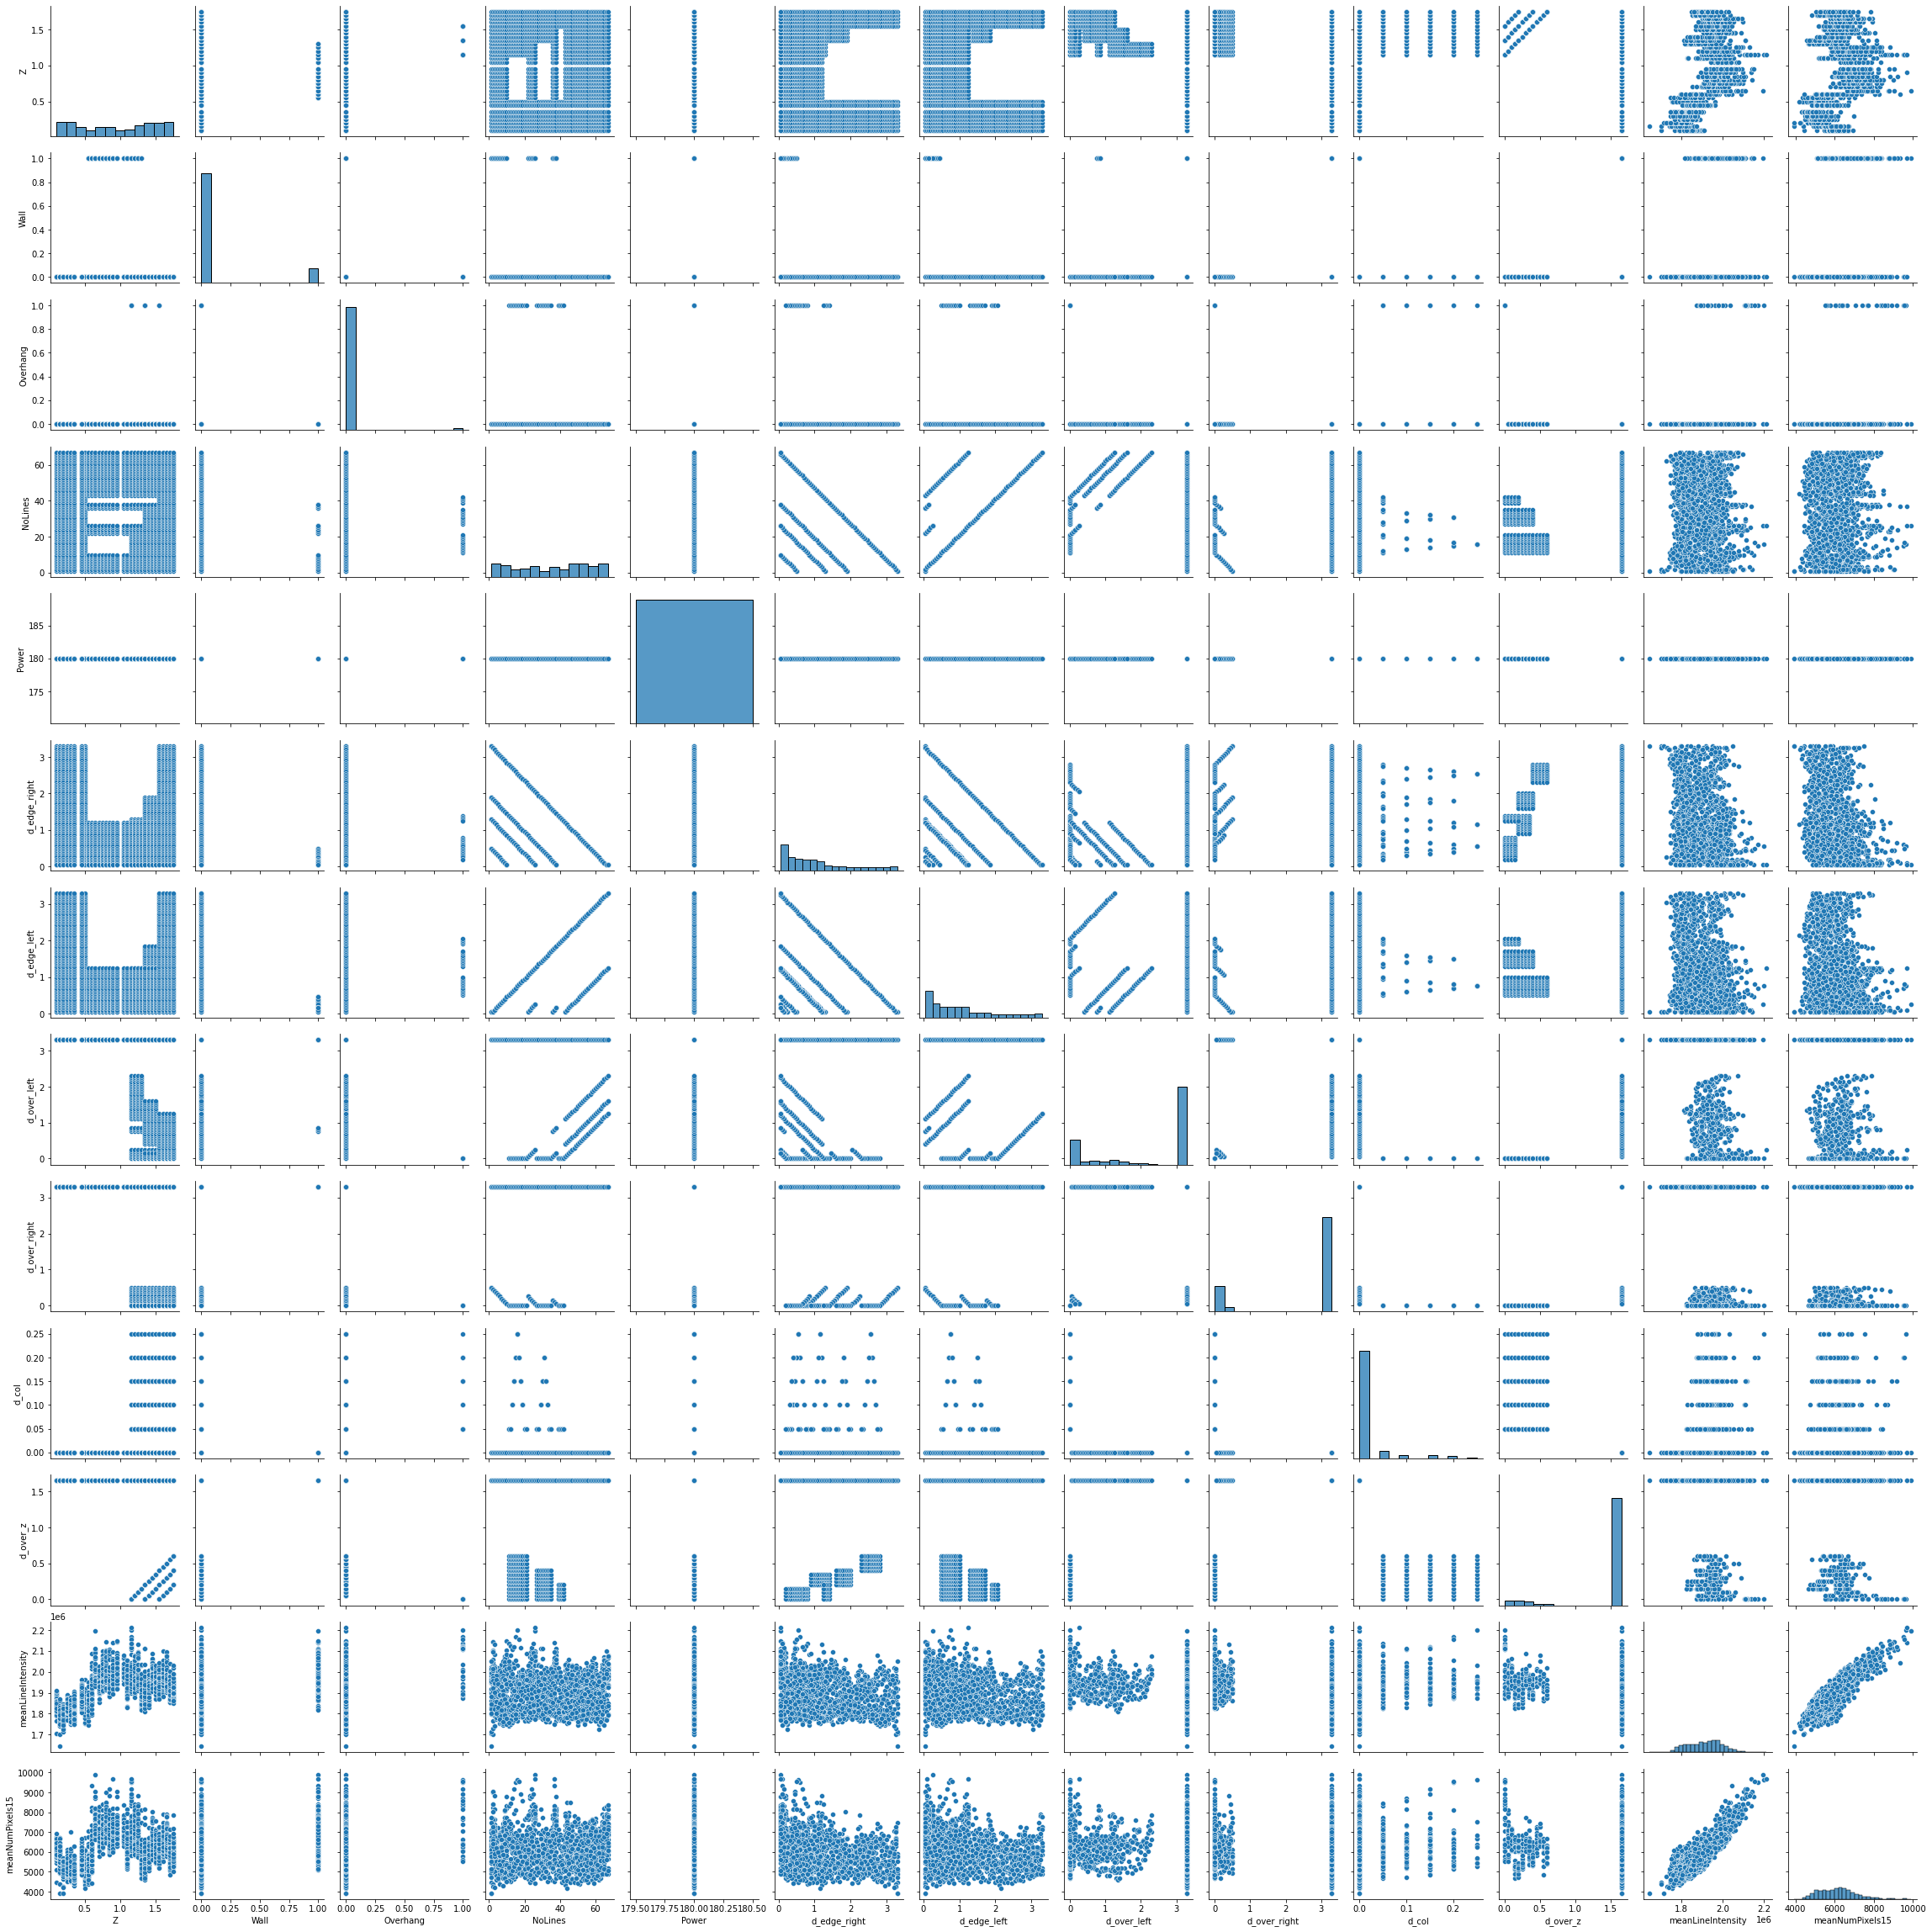

In [7]:
import seaborn as sns

sns.pairplot(data[input_cols + target_cols])
plt.show()


In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

r2s = []
for fold_no, indices in enumerate(fold_indices):
    
    X_train, X_val = X[indices[0]], X[indices[1]]
    y_train, y_val = y[indices[0]], y[indices[1]]

    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    y_pred = lr_model.predict(X_val)

    mse = mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred, multioutput='raw_values')
    print(f'Fold:  {fold_no}')
    print(f'Linear Regression MSE: {mse:.4f}')
    print(f'Linear Regression R² scores: {r2}')
    r2s.append(r2)

r2s = np.array(r2s)
mean_score = r2s.mean(axis=0)
print(f'Cross-validation mean score {mean_score}')

Fold:  0
Linear Regression MSE: 1483179941.3625
Linear Regression R² scores: [0.51605321 0.33456158]
Fold:  1
Linear Regression MSE: 1580383735.1186
Linear Regression R² scores: [0.4909124  0.29025146]
Fold:  2
Linear Regression MSE: 1724734847.0748
Linear Regression R² scores: [0.52527266 0.33800747]
Fold:  3
Linear Regression MSE: 1616719471.2695
Linear Regression R² scores: [0.56038506 0.33322526]
Fold:  4
Linear Regression MSE: 1736380389.1435
Linear Regression R² scores: [0.54586767 0.33200613]
Cross-validation mean score [0.5276982  0.32561038]


In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_val)

mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred, multioutput='raw_values')
print(f'Random Forest MSE: {mse:.4f}')
print(f'Random Forest R² scores: {r2}')
